In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pickle


In [2]:
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor

In [3]:
FOLDER_PATH = os.getcwd()
FILE_NAME = "\\nyc_traffic_ml_orig.csv"
FILE_PATH = FOLDER_PATH + FILE_NAME
nyc_traffic_ml_orig = pd.read_csv(FILE_PATH)
nyc_traffic_ml = nyc_traffic_ml_orig.copy()

In [4]:
STDEV_THRESHOLD = 1
def categorize_traffic_volume(x):
    if x < -STDEV_THRESHOLD:
        category = 1
    elif x > STDEV_THRESHOLD:
        category = 3
    else:
        category = 2
    return category

In [5]:
# You can drop any features you don't like by not adding them to to the SELECTED_COLUMNS list
# but no matter what, Traffic_Volume must always be in it.
MAIN_OUTPUT_COLUMN  = "Traffic_Volume"

SELECTED_COLUMNS = [MAIN_OUTPUT_COLUMN]
SELECTED_COLUMNS += ["Segment_ID"]
SELECTED_COLUMNS += ["Is_Weekend"]

SELECTED_COLUMNS += ["Daylight"]
SELECTED_COLUMNS += ["Season{0}".format(i) for i in [1, 2, 4]]
SELECTED_COLUMNS += ["Hr{0}".format(i) for i in range(3, 27, 3)]
SELECTED_COLUMNS += ["NumFloors"]
SELECTED_COLUMNS += ["UnitsRes_Prop"]
SELECTED_COLUMNS += ["StreetWidth"]
SELECTED_COLUMNS += ["SubwayProximity"]

SELECTED_COLUMNS += ["BoroCode{0}".format(i) for i in range(1, 6,1)]
SELECTED_COLUMNS += ["LandUse_t{0}".format(i) for i in range(1, 6,1)]
nyc_traffic_ml = nyc_traffic_ml_orig.copy()[SELECTED_COLUMNS]

In [6]:
nyc_traffic_ml = nyc_traffic_ml.sample(frac=1)

4.041327797268121


(29.0, 0)

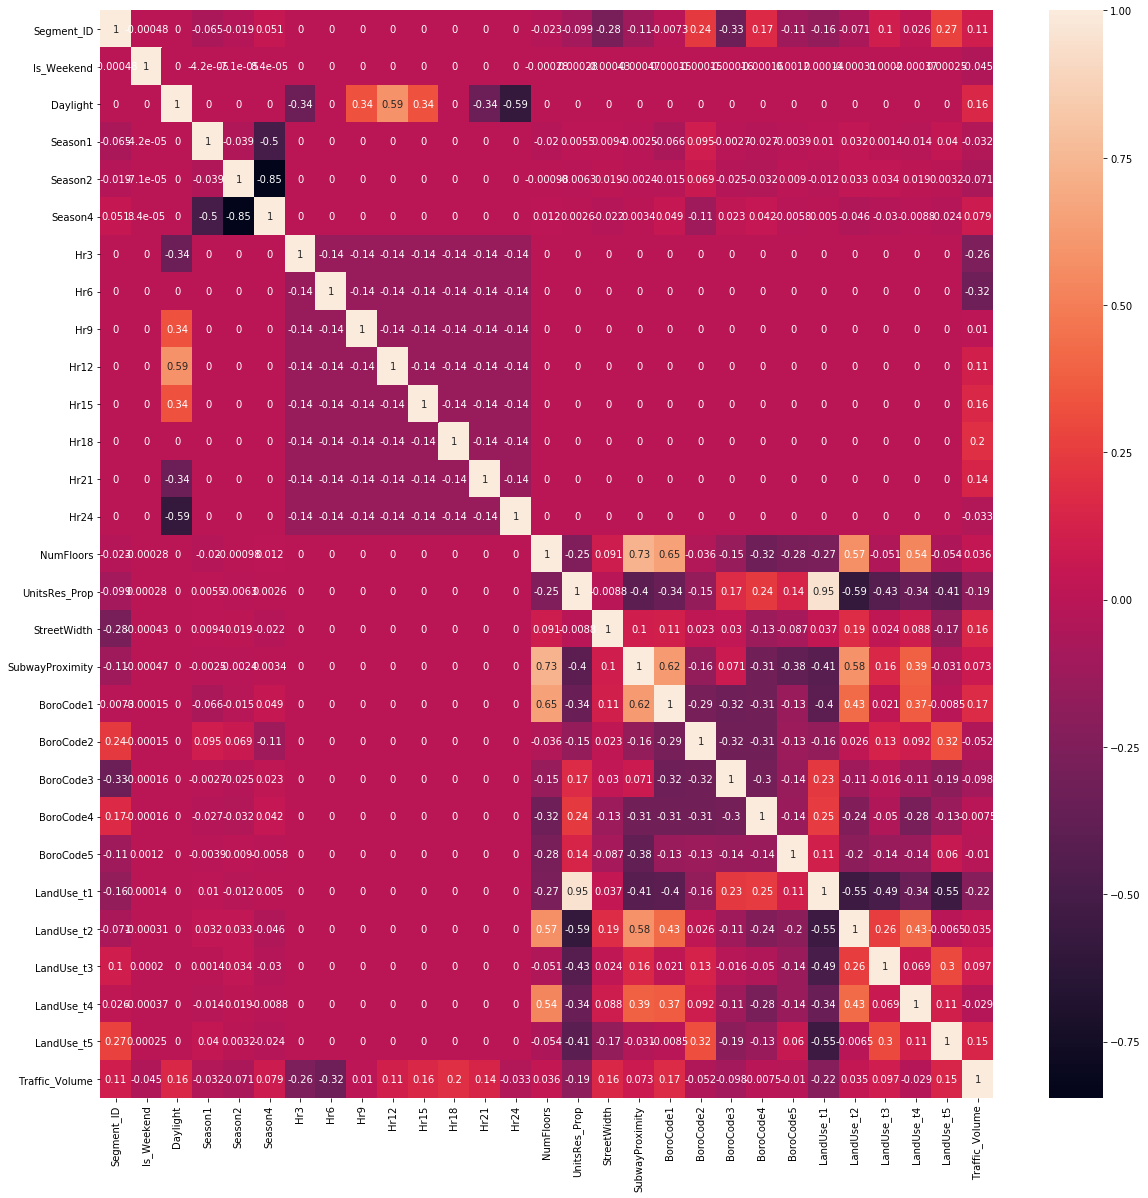

In [7]:
Corr_df = nyc_traffic_ml.drop(columns=["Traffic_Volume"])
Corr_df["Traffic_Volume"] = nyc_traffic_ml["Traffic_Volume"] # only to put traffic volume at end, + before log categorization

CORR_METHOD = ["pearson","spearman","kendall"][1]
corrMatrix = Corr_df.corr(method = CORR_METHOD)

quality = corrMatrix[corrMatrix.columns[-1]].abs().sum()
print(quality)
fig, ax = plt.subplots(figsize=(20,20)) 

ax = sns.heatmap(corrMatrix, annot=True) #notation: "annot" not "annote"
y_lims = ax.get_ylim()

ax.set_ylim(sum(y_lims), 0)

In [8]:
# but we might only need the hour columns and the landuse columns
MAIN_OUTPUT_COLUMN  = "Traffic_Volume"

SELECTED_COLUMNS = [MAIN_OUTPUT_COLUMN]
#SELECTED_COLUMNS += ["Segment_ID"]
#SELECTED_COLUMNS += ["Is_Weekend"]

#SELECTED_COLUMNS += ["Daylight"]
#SELECTED_COLUMNS += ["Season{0}".format(i) for i in [1, 2, 4]]
SELECTED_COLUMNS += ["Hr{0}".format(i) for i in range(3, 27, 3)]
#SELECTED_COLUMNS += ["NumFloors"]
#SELECTED_COLUMNS += ["UnitsRes_Prop"]
#SELECTED_COLUMNS += ["StreetWidth"]
#SELECTED_COLUMNS += ["SubwayProximity"]

#SELECTED_COLUMNS += ["BoroCode{0}".format(i) for i in range(1, 6,1)]
SELECTED_COLUMNS += ["LandUse_t{0}".format(i) for i in range(1, 6,1)]
nyc_traffic_ml = nyc_traffic_ml_orig.copy()[SELECTED_COLUMNS]

In [9]:
MODEL_INPUT_DF_OUTPUT_COLUMN = MAIN_OUTPUT_COLUMN

nyc_traffic_ml[MODEL_INPUT_DF_OUTPUT_COLUMN] = (nyc_traffic_ml[MODEL_INPUT_DF_OUTPUT_COLUMN]+1).apply(np.log)

nyc_traffic_ml[MODEL_INPUT_DF_OUTPUT_COLUMN] = (
    nyc_traffic_ml[MODEL_INPUT_DF_OUTPUT_COLUMN] - 
    nyc_traffic_ml[MODEL_INPUT_DF_OUTPUT_COLUMN].mean())/(nyc_traffic_ml[MODEL_INPUT_DF_OUTPUT_COLUMN].std())

nyc_traffic_ml[MODEL_INPUT_DF_OUTPUT_COLUMN] = nyc_traffic_ml[MODEL_INPUT_DF_OUTPUT_COLUMN].apply(categorize_traffic_volume)

In [10]:
MODEL_INPUT_DF_OUTPUT_COLUMNS = []
MODEL_INPUT_DF_OUTPUT_COLUMNS += [MODEL_INPUT_DF_OUTPUT_COLUMN]
MODEL_INPUT_DF_INPUT_COLUMNS = []
MODEL_INPUT_DF_INPUT_COLUMNS += list(nyc_traffic_ml.drop(columns=MODEL_INPUT_DF_OUTPUT_COLUMNS).columns.values)
model_input_df = nyc_traffic_ml.copy()

In [11]:
categ_columns = []
numer_columns = MODEL_INPUT_DF_INPUT_COLUMNS

In [12]:
##creating ct0 pipeline

categ_columns_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="constant", fill_value="NULL")),
    ("one-hot", OneHotEncoder(sparse=True,handle_unknown="ignore")),
])

numer_columns_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="constant", fill_value=0))
])


ct0 = ColumnTransformer([
    ("categ",categ_columns_pipeline,categ_columns),
    ("numer",numer_columns_pipeline,numer_columns)
])

In [13]:
MODEL = RandomForestClassifier(class_weight="balanced")
pl_cl_model = Pipeline([
        ("features", ct0),
        ("model", MODEL)
])

y = model_input_df[MODEL_INPUT_DF_OUTPUT_COLUMN]
X = model_input_df[MODEL_INPUT_DF_INPUT_COLUMNS]

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)
pl_cl_model.fit(X_train, y_train)
print("Cross val score:", cross_val_score(pl_cl_model, X_train, y_train, cv=4))
print("Score:", pl_cl_model.score(X_test, y_test))

Cross val score: [0.84557196 0.84797048 0.85218675 0.84609707]
Score: 0.8639634652643233


In [14]:
def MODEL_IMPLEMENTER(MODEL, MODEL_NAME):

    pl_cl_model = Pipeline([
        ("features", ct0),
        ("model", MODEL)
    ])


    y = model_input_df[MODEL_INPUT_DF_OUTPUT_COLUMN]
    X = model_input_df[MODEL_INPUT_DF_INPUT_COLUMNS]

    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y)
    pl_cl_model.fit(X_train, y_train)
    base_rand_score = pl_cl_model.score(X_test, y_test)
    
    print(MODEL_NAME)
    scores_base = [base_rand_score]
    topscore = -1
    topseed = -1
    coeffs_list = []
    trials_num = 1
    for i in range(0, trials_num):
        if (i+1)%10==0: print(i+1,"of", trials_num);
        rand_seed = i
        np.random.seed(rand_seed)
        pl_cl_model.fit(X_train, y_train)
        score = pl_cl_model.score(X_test, y_test)
        if score >= topscore:
            topscore = score
            topseed = rand_seed
        scores_base.append(score)
    np.random.seed(topseed)
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y)
    pl_cl_model.fit(X_train, y_train)
    print("Cross val score:", cross_val_score(pl_cl_model, X_train, y_train, cv=4))
    print("Score:", pl_cl_model.score(X_test, y_test))
    return [pl_cl_model, scores_base]

RandomForestClassifier
Cross val score: [0.85166052 0.84944649 0.84868057 0.84757335]
Score: 0.8693606421256573


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.86894547, 0.86901467, 0.86908386, 0.86915306, 0.86922225,
        0.86929145, 0.86936064, 0.86942984, 0.86949903, 0.86956823,
        0.86963742]),
 <a list of 10 Patch objects>)

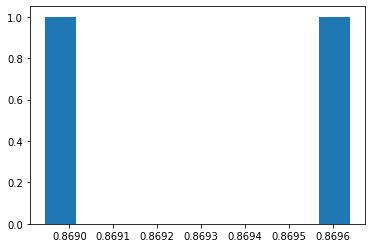

In [15]:
MODEL = RandomForestClassifier(class_weight="balanced")
MODEL_RESULTS1 = MODEL_IMPLEMENTER(MODEL, "RandomForestClassifier")
plt.hist(MODEL_RESULTS1[1])

In [16]:
pl_cl_model = MODEL_RESULTS1[0]

In [17]:
from sklearn.metrics import confusion_matrix

In [18]:
y_preds = pl_cl_model.predict(X_test)

confusionMatrix = confusion_matrix(y_preds, y_test.values
)

In [22]:
confusionMatrix_normalized = (
    confusionMatrix/(confusionMatrix.astype(np.float)).sum(axis=1)
)
confusionMatrix_normalized

array([[0.797145  , 0.05660377, 0.00254669],
       [0.0608565 , 0.9741361 , 0.03480475],
       [0.00976709, 0.03837185, 0.83531409]])

(3.0, 0)

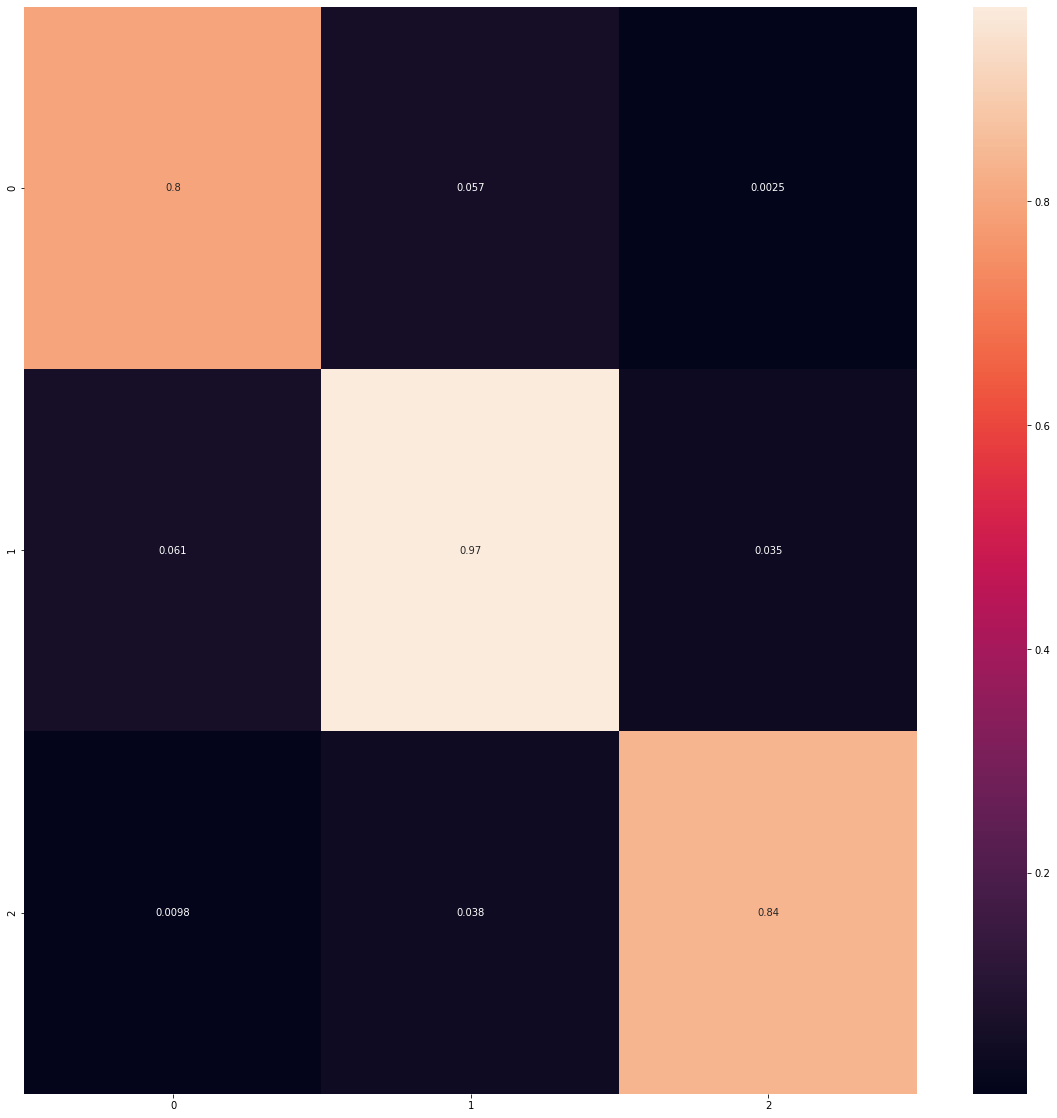

In [23]:
fig, ax = plt.subplots(figsize=(20,20)) 

ax = sns.heatmap(confusionMatrix_normalized, annot=True) #notation: "annot" not "annote"
y_lims = ax.get_ylim()

ax.set_ylim(sum(y_lims), 0)

In [ ]:
# save
with open('nyc_traffic_cl_model.pkl','wb') as f:
    pickle.dump(pl_cl_model,f)

pl_cl_model = pickle.load( open( "nyc_traffic_cl_model.pkl", "rb" ) )